In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import scienceplots

from nanonets import NanoparticleTunneling
from nanonets.utils import get_all_matrices_lattice, get_self_capacitance, get_tau_f0_SET, get_charging_energies, get_scaling_factor
from nanonets.utils import get_potential_phasor_lattice, get_current_phasor_lattice
import matplotlib.colors as mcolors

plt.style.use(["science","bright","grid"])

TAU_SET, F0_SET = get_tau_f0_SET()

def get_e_pos(L):
    return  [[(L-1)//2, 0],[0, 0],[L-1, 0],[0, (L-1)//2],[L-1, (L-1)//2],[0, L-1],[L-1, L-1],[(L-1)//2, L-1]]

### Comparing FDM & Approximation Matrix

In [2]:
L           = 7
cap0_vals   = [0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0]

C_mat_true  = np.loadtxt(f"data_ref/c_mat_L={L}_new.csv")
C_u_true    = np.loadtxt(f"data_ref/c_ele_L={L}_new.csv")[:-1,:].T
cop_true    = np.linalg.inv(C_mat_true) @ C_u_true
U, s, Vh    = np.linalg.svd(cop_true, full_matrices=True)
svd_true    = s

C_mat_short = []
C_u_short   = []
cop_short   = []  
svd_short   = []
for cap0 in cap0_vals:
    G_mat, G_u, C_mat, C_u  = get_all_matrices_lattice(L, get_e_pos(L), short_range=True)
    C_u                     = C_u.T
    C_mat                   = C_mat - (np.sum(C_mat,axis=1)-np.sum(C_u,axis=1))*np.eye(L*L,L*L) + np.eye(L*L,L*L)*cap0
    cop_mat                 = np.linalg.inv(C_mat) @ C_u
    U, s, Vh                = np.linalg.svd(cop_mat, full_matrices=True)
    
    C_mat_short.append(C_mat)
    C_u_short.append(C_u)
    cop_short.append(cop_mat)
    svd_short.append(s)

In [6]:
C_mat_short[2]

array([[ 8.66781023, -2.55593674,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-2.55593674,  8.66781023, -2.55593674, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -2.55593674,  8.66781023, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  8.66781023,
        -2.55593674,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -2.55593674,
         8.66781023, -2.55593674],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -2.55593674,  8.66781023]])

In [11]:
G_mat, G_u, C_mat, C_u  = get_all_matrices_lattice(L, get_e_pos(L), short_range=True)
0.05*C_mat[L*L//2,L*L//2]*25*1e6*1e-18

1.4029683722796917e-11

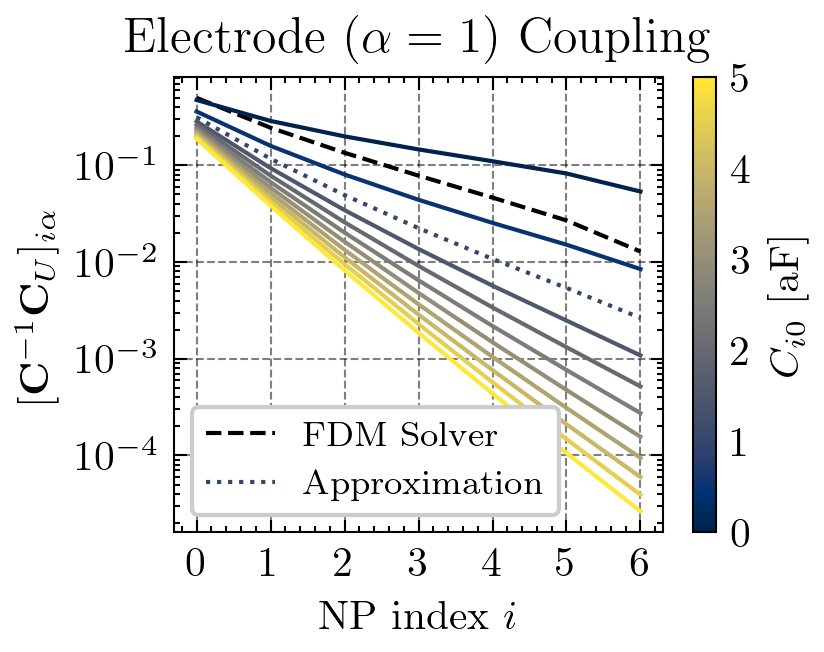

In [ ]:
idx_on_line = [L//2 + n*L for n in range(L)]
cmap        = plt.get_cmap('cividis')
norm        = mcolors.Normalize(vmin=min(cap0_vals),vmax=max(cap0_vals))
fig, ax     = plt.subplots(dpi=300)
w, h        = fig.get_size_inches()
scale       = 0.75
fig.set_size_inches(w * scale, h * scale)

_   = ax.plot(cop_true[idx_on_line,0], label='FDM Solver', color='black', ls='--')
for i, cap0 in enumerate(cap0_vals):
    if cap0 == 1.0:
        _   = ax.plot(cop_short[i][idx_on_line,0], color=cmap(norm(cap0)), ls=':', label='Approximation')
    else:
        _   = ax.plot(cop_short[i][idx_on_line,0], color=cmap(norm(cap0)))
_   = ax.set_xticks(np.arange(L))
_   = ax.set_yscale('log')
_   = ax.set_xlabel("NP index $i$")
_   = ax.set_ylabel("$[\mathbf{C}^{-1}\mathbf{C}_U]_{i\\alpha}$")
_   = ax.set_title("Electrode ($\\alpha=1$) Coupling")
_   = ax.legend(fontsize='small')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$C_{i0}~[\mathrm{aF}]$")

fig.savefig(f"plots/pdf/Coupling_Mat_FDM_vs_Short.pdf", transparent=False)
fig.savefig(f"plots/svg/Coupling_Mat_FDM_vs_Short.svg", transparent=True)
fig.savefig(f"plots/png/Coupling_Mat_FDM_vs_Short.png", transparent=False)

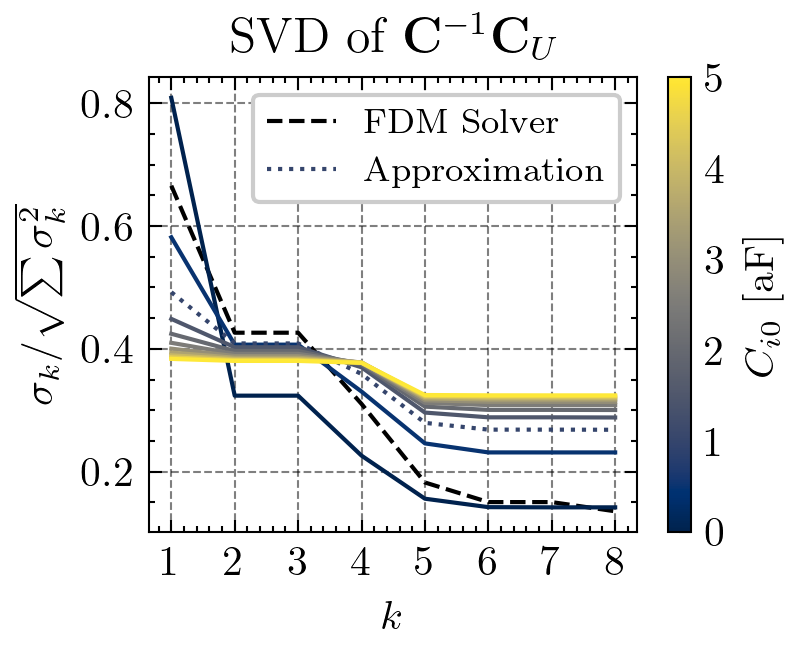

In [5]:
cmap        = plt.get_cmap('cividis')
norm        = mcolors.Normalize(vmin=min(cap0_vals),vmax=max(cap0_vals))
fig, ax     = plt.subplots(dpi=300)
w, h        = fig.get_size_inches()
scale       = 0.75
fig.set_size_inches(w * scale, h * scale)

_   = ax.plot(np.arange(1,9), svd_true/np.sqrt(np.sum(svd_true**2)), label='FDM Solver', color='black', ls='--')
for i, cap0 in enumerate(cap0_vals):
    if cap0 == 1.0:
        _ = ax.plot(np.arange(1,9), svd_short[i]/np.sqrt(np.sum(svd_short[i]**2)), color=cmap(norm(cap0)), ls=':', label='Approximation')
    else:
        _ = ax.plot(np.arange(1,9), svd_short[i]/np.sqrt(np.sum(svd_short[i]**2)), color=cmap(norm(cap0)))
_   = ax.set_xticks(np.arange(1,9))
_   = ax.set_xlabel("$k$")
_   = ax.set_ylabel("$\sigma_k / \\sqrt{\sum\sigma_k^2}$")
_   = ax.set_title("SVD of $\mathbf{C}^{-1}\mathbf{C}_U$")
_   = ax.legend(fontsize='small', loc='upper right')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$C_{i0}~[\mathrm{aF}]$")

fig.savefig(f"plots/pdf/SVD_FDM_vs_Short.pdf", transparent=False)
fig.savefig(f"plots/svg/SVD_FDM_vs_Short.svg", transparent=True)
fig.savefig(f"plots/png/SVD_FDM_vs_Short.png", transparent=False)

### Charging Energy and Scaling

In [34]:
L_vals  = [3,5,7,9,11,13,15]
cap0    = 1.0
e_short = {}
cop_mat = {}
for L in L_vals:
    G_mat, G_u, C_mat, C_u  = get_all_matrices_lattice(L, get_e_pos(L), short_range=True)
    C_u                     = C_u.T
    C_mat                   = C_mat - (np.sum(C_mat,axis=1)-np.sum(C_u,axis=1))*np.eye(L*L,L*L) + np.eye(L*L,L*L)*cap0
    C_inv                   = np.linalg.inv(C_mat)
    cop_mat[L]              = np.min((C_inv@C_u)[:,0])
    e_short[f"$L = {L}$"]   = 2*1000*get_charging_energies(C_inv)/0.160217662

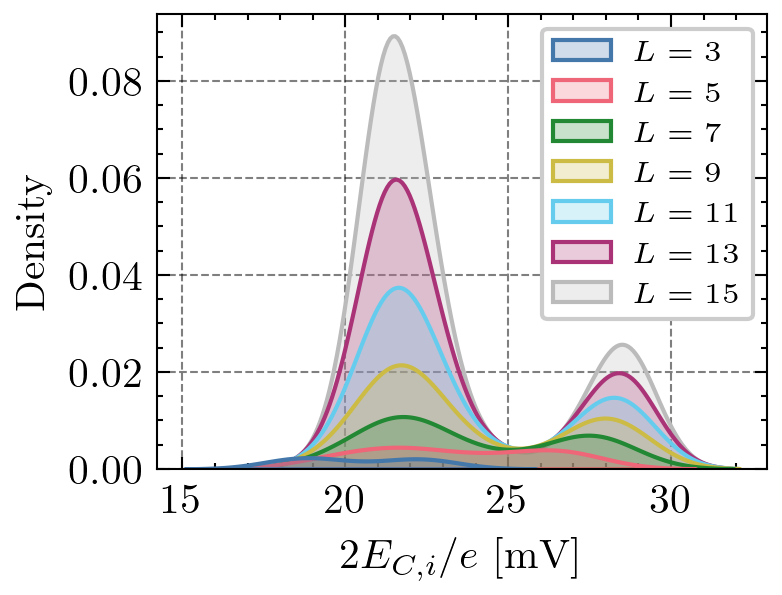

In [37]:
fig, ax     = plt.subplots(dpi=300)
w, h        = fig.get_size_inches()
scale       = 0.75
fig.set_size_inches(w * scale, h * scale)

_ = sns.kdeplot(e_short, fill=True, ax=ax)
_ = sns.move_legend(ax, 'upper right', fontsize='x-small')
# _ = ax.set_xlim(15,35)
_ = ax.set_xlabel("$2 E_{C,i} / e~[\mathrm{mV}]$")

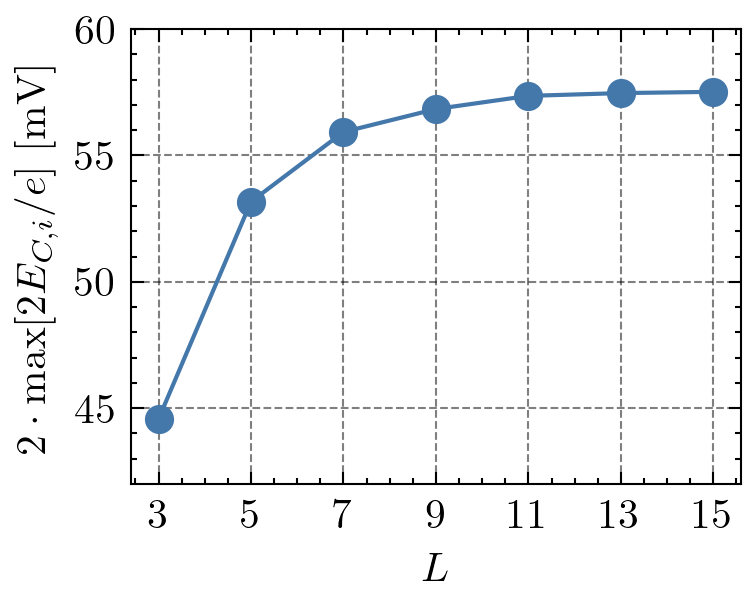

In [53]:
max_e   = np.array([2*np.max(val) for _, val in e_short.items()])
scaling = np.array([get_scaling_factor(L)[0] for L in L_vals])

fig, ax = plt.subplots(dpi=300)
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

_ = ax.plot(L_vals, np.round(max_e,2), marker='o')
# _ = ax.plot(L_vals, np.round(scaling*max_e,2))
_ = ax.set_xticks(L_vals)
_ = ax.set_ylim(42,60)
_ = ax.set_xlabel("$L$")
_ = ax.set_ylabel("$2\cdot\\max[2 E_{C,i} / e]~[\mathrm{mV}]$")

In [39]:
max_e

array([22.28696255, 26.58563214, 27.96259045, 28.42025098, 28.67764318,
       28.73373117, 28.76043163])

### Test Run

### Time Dependent Simulation

In [ ]:
FREQ_LIST   = np.logspace(-2,5,100)
nu_LIST     = FREQ_LIST / F0_SET

In [ ]:
fig, ax     = plt.subplots(dpi=300)
w, h        = fig.get_size_inches()
scale       = 0.75
fig.set_size_inches(w * scale, h * scale)

# FDM Solver
pp      = ax.plot(nu_LIST, gain_I_true, label='FDM Solver')
for rate in poles_true[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Short Range
pp      = ax.plot(nu_LIST, gain_I_short, label='Short Range')
for rate in poles_short[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Long Range
pp      = ax.plot(nu_LIST, gain_I_long, label='Long Range')
for rate in poles_long[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Params
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_xlim(1e-4, 1e2)
_ = ax.set_ylabel("$\mathcal{G}_I(\\nu)$ [dB]")
_ = ax.legend(fontsize='small')


# fig.savefig(f"plots/pdf/KCL_gain_I_FDM_Short_Long.pdf", transparent=False)
# fig.savefig(f"plots/svg/KCL_gain_I_FDM_Short_Long.svg", transparent=True)
# fig.savefig(f"plots/png/KCL_gain_I_FDM_Short_Long.png", transparent=False)

In [ ]:
fig, ax     = plt.subplots(dpi=300)
w, h        = fig.get_size_inches()
scale       = 0.75
fig.set_size_inches(w * scale, h * scale)

# FDM Solver
pp      = ax.plot(nu_LIST, gain_p_true, label='FDM Solver')
for rate in poles_true[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Short Range
pp      = ax.plot(nu_LIST, gain_p_short, label='Short Range')
for rate in poles_short[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Long Range
pp      = ax.plot(nu_LIST, gain_p_long, label='Long Range')
for rate in poles_long[:10]:
    _   = plt.axvline(x=rate, color='k', linestyle='--', alpha=0.8, c=pp[0].get_color())

# Params
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_xlim(1e-4, 1e2)
_ = ax.set_ylabel("$\mathcal{G}_\\phi(\\nu)$ [dB]")
_ = ax.legend(fontsize='small')


# fig.savefig(f"plots/pdf/KCL_gain_phi_FDM_Short_Long.pdf", transparent=False)
# fig.savefig(f"plots/svg/KCL_gain_phi_FDM_Short_Long.svg", transparent=True)
# fig.savefig(f"plots/png/KCL_gain_phi_FDM_Short_Long.png", transparent=False)

In [ ]:
L           = 7
FREQ_LIST   = np.logspace(-2,5,100)
nu_LIST     = FREQ_LIST / F0_SET

for load,short in zip((True,False,False),(False,False,True)):
    if load:
        G_mat, G_u, C_mat, C_u  = get_all_matrices_lattice(L, get_e_pos(L), short_range=short)
        C_mat = np.loadtxt(f"data_ref/c_mat_L={L}_new.csv")
        C_u = np.loadtxt(f"data_ref/c_ele_L={L}_new.csv")
    else:
        G_mat, G_u, C_mat, C_u  = get_all_matrices_lattice(L, get_e_pos(L), load=load, short_range=short)
        C_mat = C_mat - np.eye(L*L,L*L)*get_self_capacitance()*1e-18 + 0.5*np.eye(L*L,L*L)*1e-18

    U_phasor                = np.array([0.1,0,0,0,0,0,0,0])[:,np.newaxis]
    phi_phasor              = np.mean(np.array([get_potential_phasor_lattice(G_mat, G_u, C_mat, C_u, U_phasor, 2*np.pi*freq*1e6).flatten() for freq in FREQ_LIST]),axis=1)
    I_phasor                = np.array([get_current_phasor_lattice(G_mat, G_u, C_mat, C_u, U_phasor, 2*np.pi*freq*1e6).flatten() for freq in FREQ_LIST])
    eigenvals, eigenvecs    = scipy.linalg.eig(G_mat, C_mat)
    poles_rad_s             = np.sort(np.real(eigenvals)) / (2 * np.pi)
    nu_poles                = poles_rad_s*1e-6 / F0_SET
    coup_matrix             = -1.0*np.linalg.inv(C_mat)@C_u
    U, s, Vh                = np.linalg.svd(coup_matrix, full_matrices=True)

    if load:
        gain_I_true = 20*np.log10(np.abs(I_phasor / I_phasor[0])).flatten()
        gain_p_true = 20*np.log10(np.abs(phi_phasor / phi_phasor[0])).flatten()
        C_mat_true  = C_mat
        C_u_true    = C_u
        poles_true  = nu_poles
        coup_true   = coup_matrix
        svd_true    = s
    else:
        if short:
            gain_I_short = 20*np.log10(np.abs(I_phasor / I_phasor[0])).flatten()
            gain_p_short = 20*np.log10(np.abs(phi_phasor / phi_phasor[0])).flatten()
            C_mat_short  = C_mat
            C_u_short    = C_u
            poles_short  = nu_poles
            coup_short   = coup_matrix
            svd_short    = s
        else:
            gain_I_long = 20*np.log10(np.abs(I_phasor / I_phasor[0])).flatten()
            gain_p_long = 20*np.log10(np.abs(phi_phasor / phi_phasor[0])).flatten()
            C_mat_long  = C_mat
            C_u_long    = C_u
            poles_long  = nu_poles
            coup_long   = coup_matrix
            svd_long    = s